In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [78]:
# Find the most recent date in the data set.
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1):
    print(row)

('2017-08-23',)


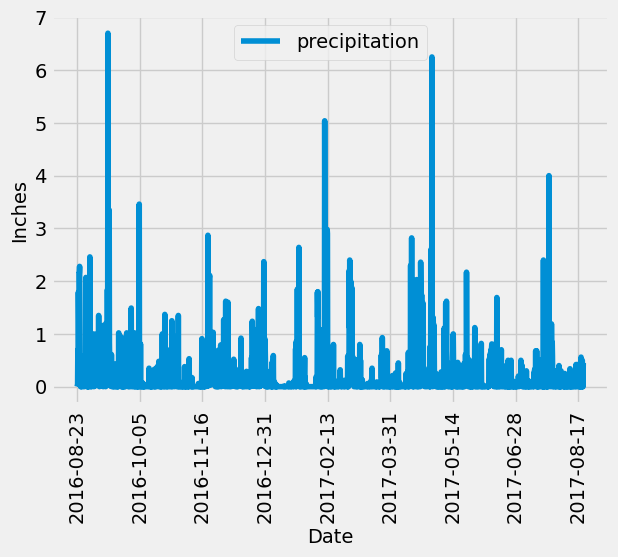

In [333]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
start_date= dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365)

#NOTE I did a second calculation for one day after a year from the latest date (8/23/16) for performing the SQL query and ensuring the 8/23/16 dates are included
#The filter was considering ">=" as ">" for some reason and would exclude the first dates I needed.
filter_date= dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > filter_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query)
df.columns=['date','precipitation']
#Set the index to date so that the x-axis will show as the date values
df.set_index('date', inplace=True)
#Drop null values
df =df.dropna()

# Sort the dataframe by date
df = df.sort_values(by=['date'], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

df.plot()
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

In [276]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [250]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [320]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_query = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
    
most_active = most_active_query[0]


session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

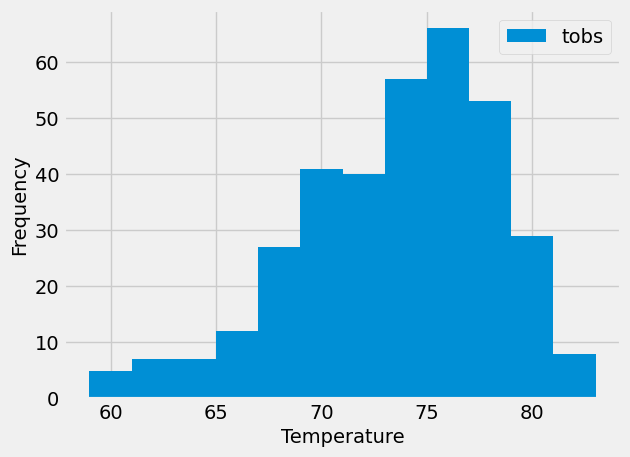

In [323]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#since the histogram will group all the information we need, we do not need to group, order oor perform extra calculations in the query
#We also only need the temp data itself for the chart output so the date and station columns will be used to filter, but won't be used for the dataframe
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > filter_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(temp_data)
#Drop null values
df =df.dropna()


df2.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()


# Close Session

In [326]:
# Close Session
session.close()